<a href="https://colab.research.google.com/github/boomboom0202/IDID/blob/main/Copy_of_Detectron2_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Beginner's Tutorial

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 4.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15777, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 15777 (delta 7), reused 22 (delta 4), pack-reused 15743 (from 1)
Receiving objects: 100% (15777/15777), 6.35 MiB | 10.75 MiB/s, done.
Resolving deltas: 100% (11503/11503), done.


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.1 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61395 sha256=9e947fd9ae86c56be6f702432ca01a6eb1f15999eeb787b9f109650a7ae5d54a
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.4 ; cuda:  cu121
detectron2: 0.6


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, DatasetMapper
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators

# Set the paths to your dataset
image_dir = '/content/drive/MyDrive/dataset/images/rcnn_dataset'
annotation_file = '/content/drive/MyDrive/dataset/annotate_coco2.json'

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


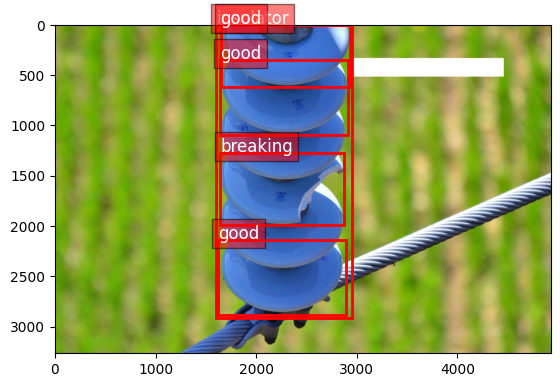

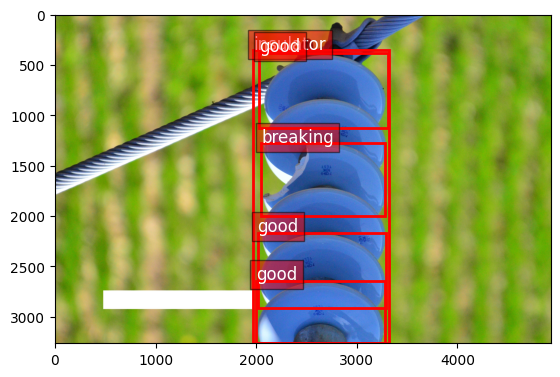

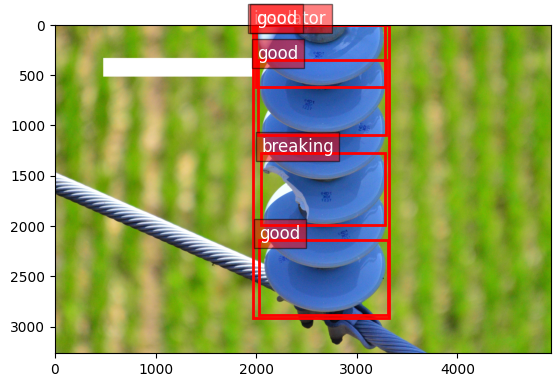

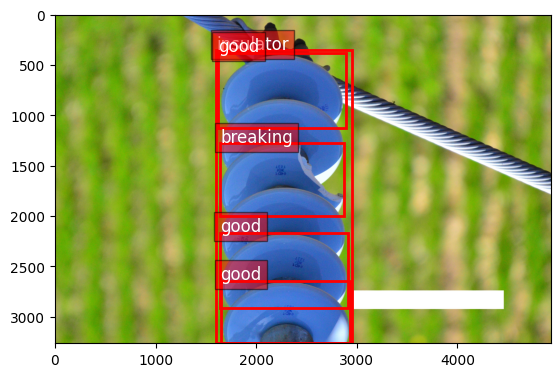

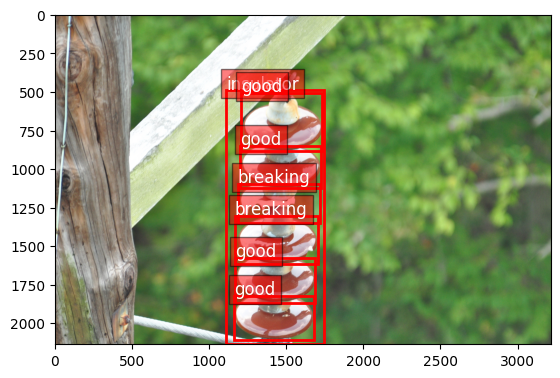

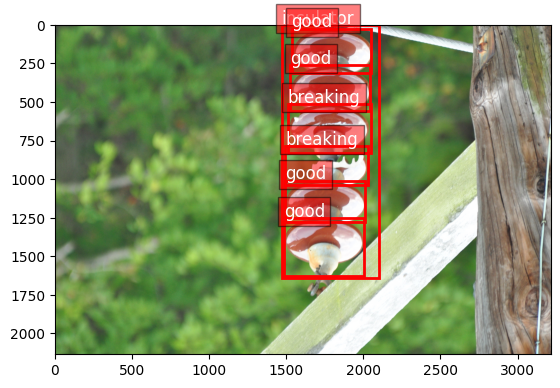

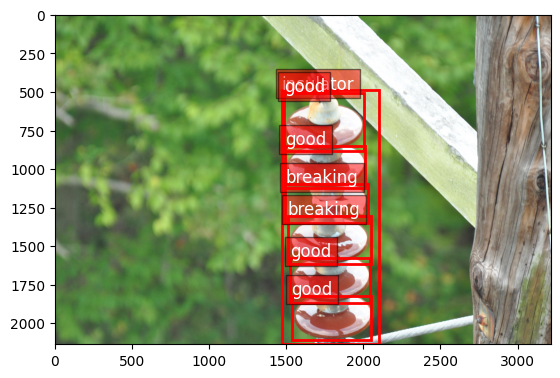

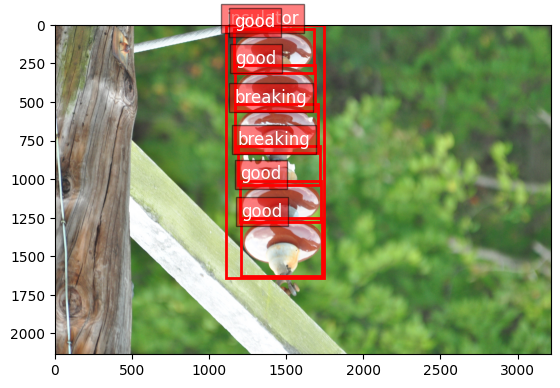

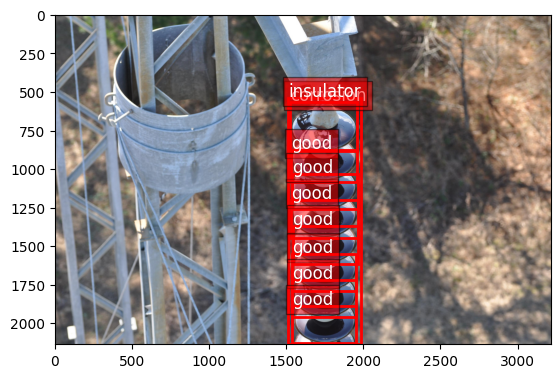

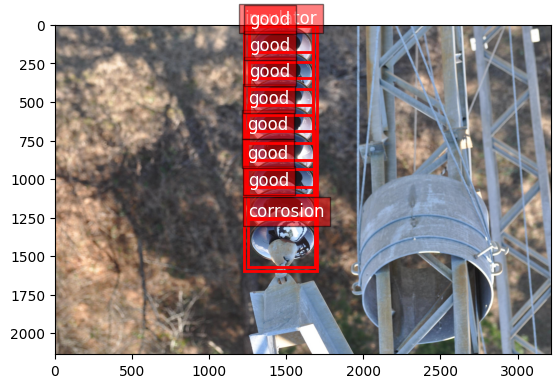

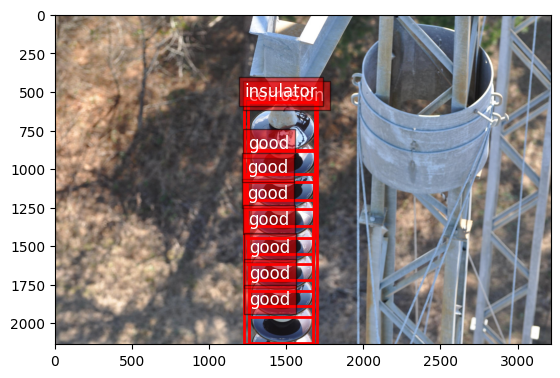

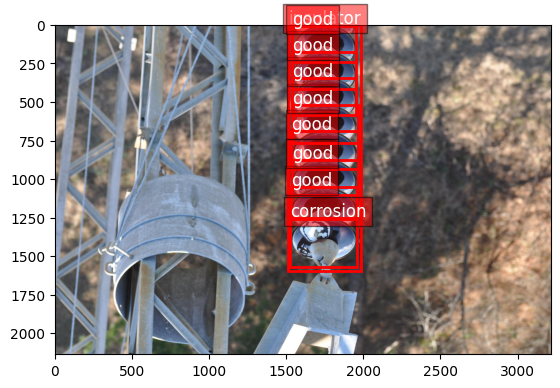

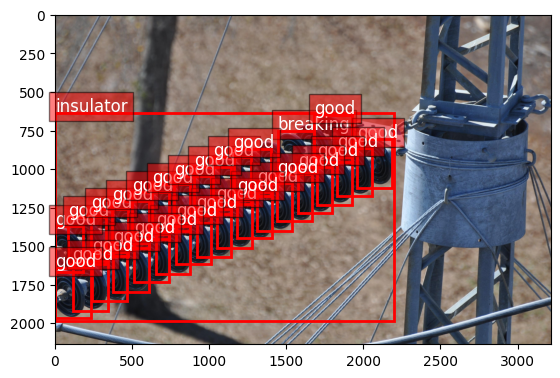

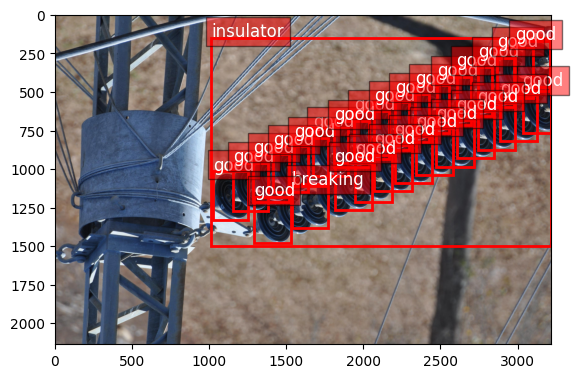

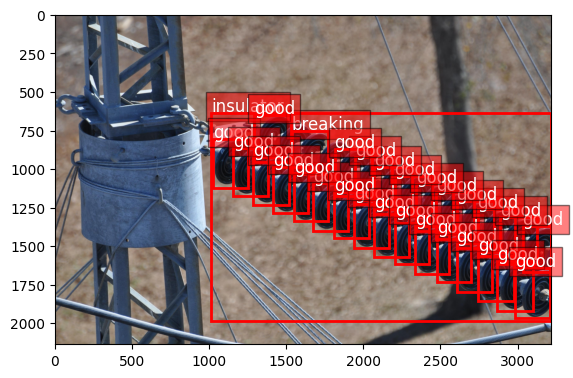

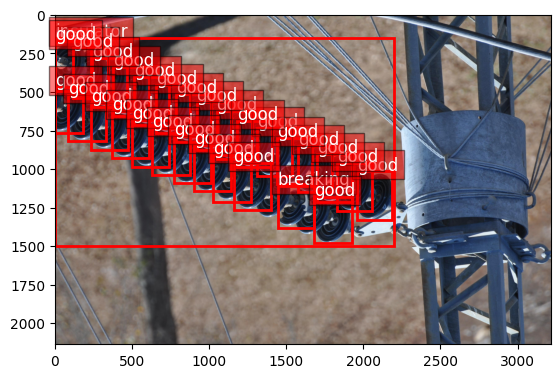

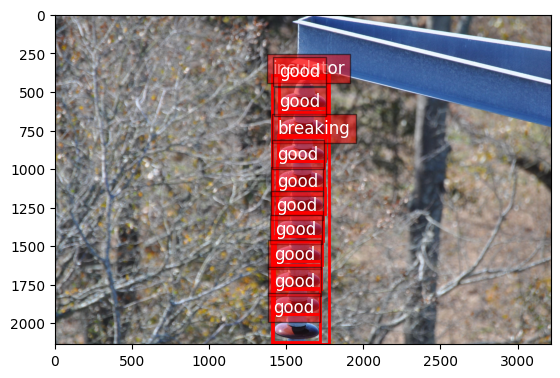

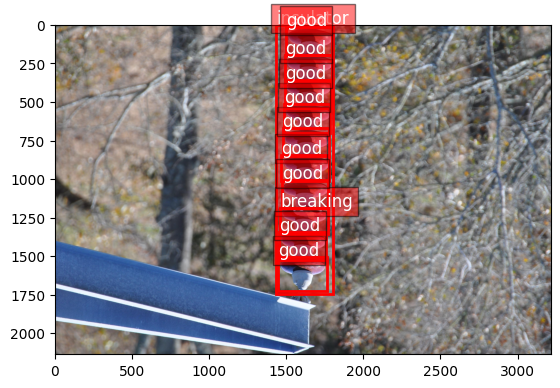

KeyboardInterrupt: 

In [ ]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# Путь к файлам
image_dir = '/content/drive/MyDrive/dataset/images/rcnn_dataset'
annotation_file = '/content/drive/MyDrive/dataset/annotate_coco2.json'

# Загрузка аннотаций COCO
coco = COCO(annotation_file)

# Получение всех id изображений
image_ids = coco.getImgIds()

# Вывод изображений с аннотациями и подписями классов
for img_id in image_ids:
    # Получаем информацию об изображении
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(image_dir, img_info['file_name'])

    # Открываем изображение
    image = Image.open(img_path)

    # Получаем аннотации для изображения
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    # Вывод изображения
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Рисуем аннотации и подписываем классы
    for ann in anns:
        bbox = ann['bbox']
        x, y, width, height = bbox

        # Рисуем рамку вокруг объекта
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Получаем имя категории
        category_id = ann['category_id']
        category_name = coco.loadCats(category_id)[0]['name']

        # Подписываем класс
        plt.text(x, y - 10, category_name, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()


[10/03 06:42:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[10/03 06:42:55 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/03 06:43:22 d2.utils.events]:  eta: 0:01:25  iter: 19  total_loss: 2.939  loss_cls: 1.726  loss_box_reg: 0.8777  loss_rpn_cls: 0.2208  loss_rpn_loc: 0.06226    time: 1.1990  last_time: 0.8432  data_time: 0.7730  last_data_time: 0.4559   lr: 4.7703e-05  max_mem: 2425M
[10/03 06:43:52 d2.utils.events]:  eta: 0:01:04  iter: 39  total_loss: 2.217  loss_cls: 1.184  loss_box_reg: 0.9434  loss_rpn_cls: 0.02271  loss_rpn_loc: 0.05825    time: 1.2024  last_time: 1.2363  data_time: 0.7454  last_data_time: 0.7406   lr: 9.7653e-05  max_mem: 2425M
[10/03 06:44:19 d2.utils.events]:  eta: 0:00:46  iter: 59  total_loss: 1.746  loss_cls: 0.7473  loss_box_reg: 0.9078  loss_rpn_cls: 0.01128  loss_rpn_loc: 0.05328    time: 1.2589  last_time: 0.6775  data_time: 0.9064  last_data_time: 0.1852   lr: 0.0001476  max_mem: 2425M
[10/03 06:44:49 d2.utils.events]:  eta: 0:00:23  iter: 79  total_loss: 1.596  loss_cls: 0.6442  loss_box_reg: 0.8757  loss_rpn_cls: 0.0103  loss_rpn_loc: 0.0507    time: 1.3156  last

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[10/03 06:45:30 d2.data.datasets.coco]: Loaded 2 images in COCO format from /content/drive/MyDrive/dataset/val_annotations.json


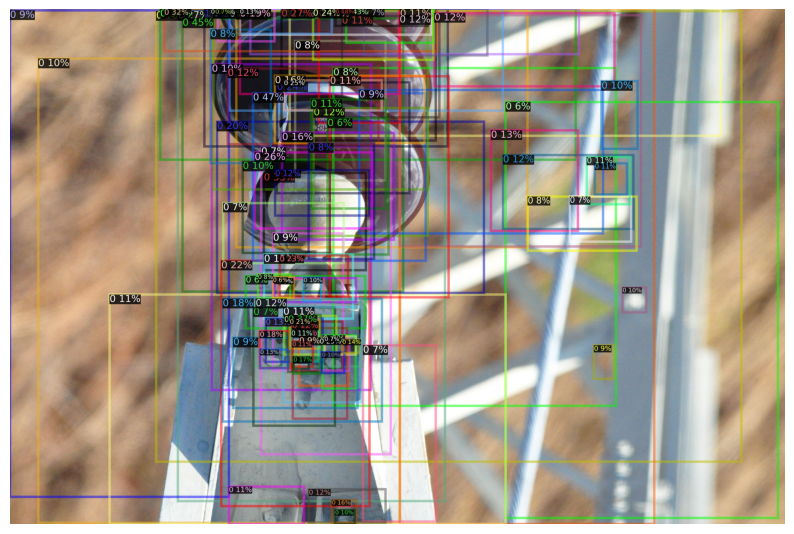

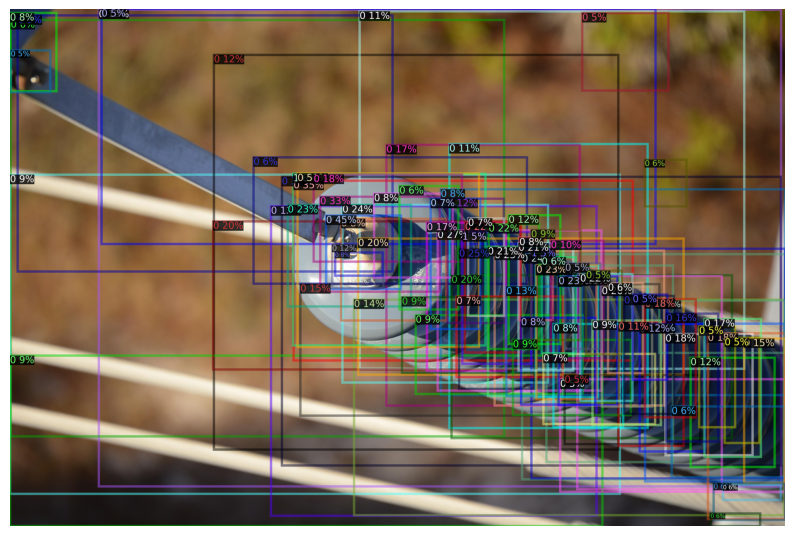

ValueError: Sample larger than population or is negative

In [ ]:
import os
import json
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import Visualizer
from detectron2.model_zoo import model_zoo

# Paths to your dataset and annotations
image_dir = '/content/drive/MyDrive/dataset/images/rcnn_dataset'
annotation_file = '/content/drive/MyDrive/dataset/annotate_coco2.json'

# Load the annotations
with open(annotation_file) as f:
    annotations = json.load(f)

# Split dataset
def stratified_split(annotations, image_dir, split_ratio=0.2):
    category_counts = {}
    for ann in annotations['annotations']:
        category_id = ann['category_id']
        category_counts[category_id] = category_counts.get(category_id, 0) + 1

    # Prepare a dictionary to store image IDs by class
    class_to_images = {cid: [] for cid in category_counts.keys()}
    for ann in annotations['annotations']:
        image_id = ann['image_id']
        class_to_images[ann['category_id']].append(image_id)

    # Split images
    train_ids = set()
    val_ids = set()

    for class_id, image_ids in class_to_images.items():
        random.shuffle(image_ids)
        split_index = int(len(image_ids) * (1 - split_ratio))
        train_ids.update(image_ids[:split_index])
        val_ids.update(image_ids[split_index:])

    # Create new annotations for train and val datasets
    train_annotations = {
        'images': [],
        'annotations': [],
        'categories': annotations['categories'],
    }
    val_annotations = {
        'images': [],
        'annotations': [],
        'categories': annotations['categories'],
    }

    for img in annotations['images']:
        if img['id'] in train_ids:
            train_annotations['images'].append(img)
        elif img['id'] in val_ids:
            val_annotations['images'].append(img)

    for ann in annotations['annotations']:
        if ann['image_id'] in train_ids:
            train_annotations['annotations'].append(ann)
        elif ann['image_id'] in val_ids:
            val_annotations['annotations'].append(ann)

    return train_annotations, val_annotations

# Perform stratified split
train_annotations, val_annotations = stratified_split(annotations, image_dir)

# Save the new annotations
train_annotation_file = '/content/drive/MyDrive/dataset/train_annotations.json'
val_annotation_file = '/content/drive/MyDrive/dataset/val_annotations.json'

with open(train_annotation_file, 'w') as f:
    json.dump(train_annotations, f)

with open(val_annotation_file, 'w') as f:
    json.dump(val_annotations, f)

# Register datasets
register_coco_instances("my_train_dataset", {}, train_annotation_file, image_dir)
register_coco_instances("my_val_dataset", {}, val_annotation_file, image_dir)

# Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_train_dataset",)
cfg.DATASETS.TEST = ("my_val_dataset",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 100  # Adjust according to your dataset size
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Default: 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(train_annotations['categories'])  # Adjust to your number of classes
cfg.OUTPUT_DIR = "./output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Train the model
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Evaluate the model
evaluator = COCOEvaluator("my_val_dataset", cfg, False, output_dir="./output/")
trainer.test(cfg, trainer.model, evaluators=[evaluator])

# Load the trained model for visualization
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
predictor = DefaultPredictor(cfg)

# Visualize predictions on a sample of images
def visualize_predictions(predictor, dataset_dicts, num_images=5):
    # Ensure num_images is not larger than the dataset
    num_images = min(num_images, len(dataset_dicts))
    for d in random.sample(dataset_dicts, num_images):
        img = cv2.imread(d["file_name"])
        outputs = predictor(img)
        v = Visualizer(img[:, :, ::-1], scale=1.2)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize=(10, 10))
        plt.imshow(v.get_image())
        plt.axis('off')
        plt.show()

# Load the dataset and visualize predictions
dataset_dicts = DatasetCatalog.get("my_val_dataset")
visualize_predictions(predictor, dataset_dicts)



# Analyze errors in predictions
analyze_errors(predictor, dataset_dicts)


In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog

train_metadata = MetadataCatalog.get("my_train_dataset")
val_metadata = MetadataCatalog.get("my_val_dataset")

print(f"Train dataset metadata: {train_metadata}")
print(f"Validation dataset metadata: {val_metadata}")